<h1>Project: Air pollution segmentation in India</h1>

The goal of this project is to find areas in India with similar air pollution characteristics.<br><br>
Data set contains levels of 3 common air pollutant:
NO2 - nitrogen dioxide from NOX family, SO2 - sulfur dioxide, and MP10 - particle matters that have a diameter of 10 micrometers (0.01 mm) or smaller.
The data was taken from Kaggle: https://www.kaggle.com/adityadeshpande23/pollution-india-2010.<br><br>
Unsupervising machine learning method implementation step are:
<ol>
  <li>EDA</li>
  <li>feature engineering</li>
  <li>feature selection</li>
  <li>clustering</li>
  <li>discussion</li>
</ol>

<b>Conclusion</b><br>
Agglomerative clustering with 3 clusters shows separation that makes sense for me. Red cluster 1 comprises the least polluted areas by all means. Light blue cluster 2 comprises the most polluted areas. Green cluster 3 low in 'SO2' and high with 'NO2' and 'PM10'.

<h2>1. EDA</h2>

In [1]:
# importing libraries
from platform import python_version
import warnings

# for working with arrays and dataframes
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy
import scipy.stats as stats # for Q-Q plots

# for scaling and clustering
import sklearn
from sklearn.preprocessing import MinMaxScaler

# for missing values imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# for clustering
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# for saving weights
import joblib

In [2]:
# showing versions
print('Python version:',python_version())
print('NumPy version:',np.__version__)
print('Pandas version:',pd.__version__)
print('SciPy version:',scipy.__version__)
print('Sklearn version:',sklearn.__version__)
print('Joblib version:',joblib.__version__)

Python version: 3.7.14
NumPy version: 1.21.6
Pandas version: 1.3.5
SciPy version: 1.7.3
Sklearn version: 1.0.2
Joblib version: 1.1.0


In [3]:
# settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [4]:
# importing the dataset
df = pd.read_csv("pollution_india_2010 (1).csv")
print(f"{df.shape[1]} columns, {df.shape[0]} rows")
# checking duplicated rows
print(f"{df.duplicated().sum()} duplicated rows")

5 columns, 181 rows
0 duplicated rows


In [5]:
# showing the column names
list(df.columns)

['City', 'NO2', 'PM10', 'SO2', 'State']

In [6]:
# reordering the dataframe columns in convinient order
df = df[['City', 'State', 'NO2', 'PM10', 'SO2']]
df.head()

,City,State,NO2,PM10,SO2
0,Chitoor,Andhra Pradesh,9,39,4
1,Guntur,Andhra Pradesh,11,81,2
2,Hydrabad,Andhra Pradesh,24,79,5
3,Kothagudem,Andhra Pradesh,11,62,2
4,Kurnool,Andhra Pradesh,9,85,4


In [7]:
# showing data types
df.dtypes

City     object
State    object
NO2      object
PM10     object
SO2      object
dtype: object

In [8]:
# converting numerical columns to float
df['NO2'] = pd.to_numeric(df['NO2'], errors='coerce')
df['PM10'] = pd.to_numeric(df['PM10'], errors='coerce')
df['SO2'] = pd.to_numeric(df['SO2'], errors='coerce')
df.dtypes

City      object
State     object
NO2      float64
PM10     float64
SO2      float64
dtype: object

In [9]:
# identifying categorical values
# capturing type object
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
cat_vars

['City', 'State']

In [10]:
# casting all variables as string
df[cat_vars] = df[cat_vars].astype('str')
df.dtypes

City      object
State     object
NO2      float64
PM10     float64
SO2      float64
dtype: object

<h3>Numerical variables</h3>

In [11]:
# identifying the numerical variables
num_vars = [var for var in df.columns if var not in cat_vars]
num_vars

['NO2', 'PM10', 'SO2']

In [12]:
# making a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

# determining percentage of missing values (expressed as decimals)
# and displaying the result ordered by percent of missin data

df[vars_with_na].isnull().mean().sort_values(ascending=False)

SO2     0.027624
NO2     0.022099
PM10    0.005525
dtype: float64

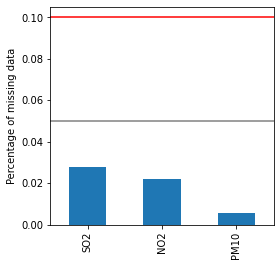

In [13]:
# plotting variables with missing values
df[vars_with_na].isnull().mean().sort_values(ascending=False).plot.bar(figsize=(4, 4))
plt.ylabel('Percentage of missing data')
plt.axhline(y=0.10, color='r', linestyle='-')
plt.axhline(y=0.05, color='grey', linestyle='-')
plt.show()

In [14]:
# function to create histogram, Q-Q plot and boxplot
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

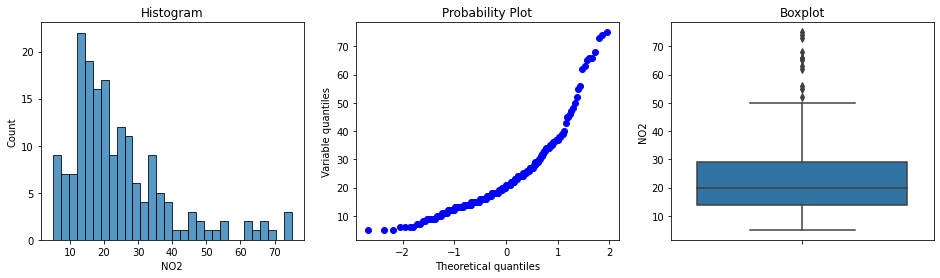

Skewnessis of NO2 is 1.52


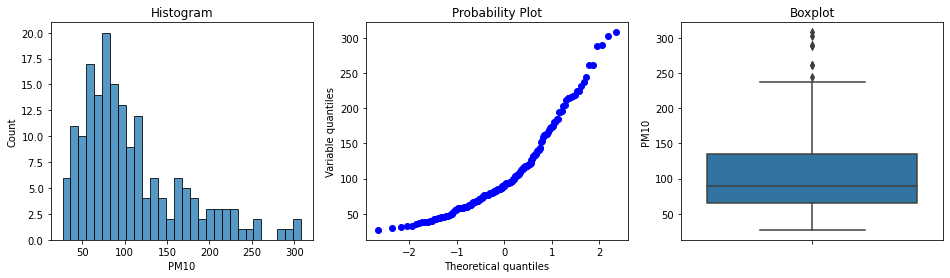

Skewnessis of PM10 is 1.20


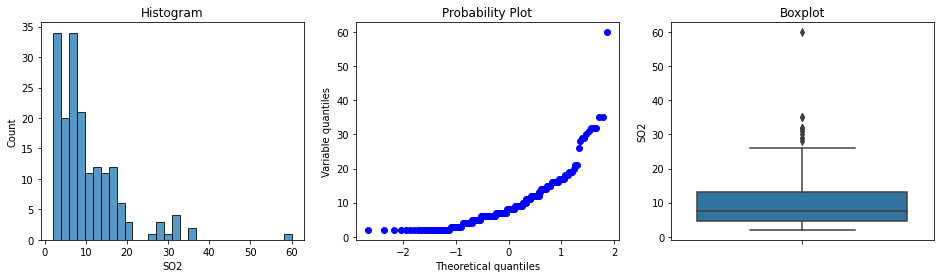

Skewnessis of SO2 is 2.24


In [15]:
# plotting NO2 variable
for variable in num_vars:
    diagnostic_plots(df, variable)
    # printing skewness
    skewness = df[variable].skew()
    print("Skewnessis of", variable, "is {:.2f}".format(skewness))

<h3>Categorical variables</h3>

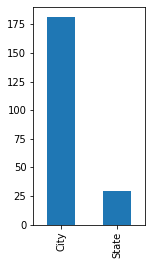

In [16]:
# counting unique categories with pandas unique() 
# and then plotting them in descending order
df[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(2,4))

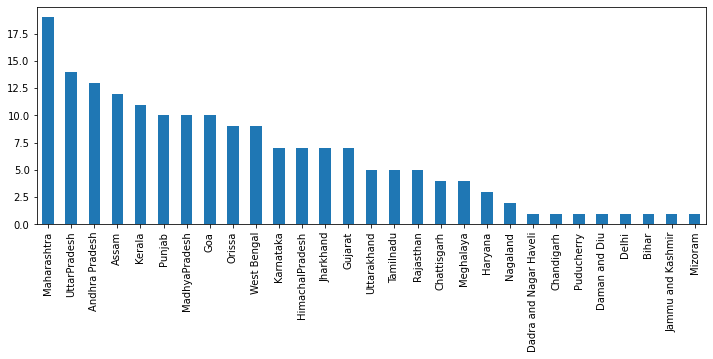

In [17]:
# counting observations per state
df['State'].value_counts(dropna=False).plot.bar(figsize=(12,4))

In [18]:
# calculating mean values per state
df_state = df.groupby('State').mean()
df_state.head()

,NO2,PM10,SO2
State,,,
Andhra Pradesh,14.076923,68.692308,4.615385
Assam,14.750000,69.500000,6.166667
Bihar,40.000000,181.000000,7.000000
Chandigarh,16.000000,92.000000,2.000000
Chattisgarh,26.250000,167.333333,11.250000


Average NO2 per state


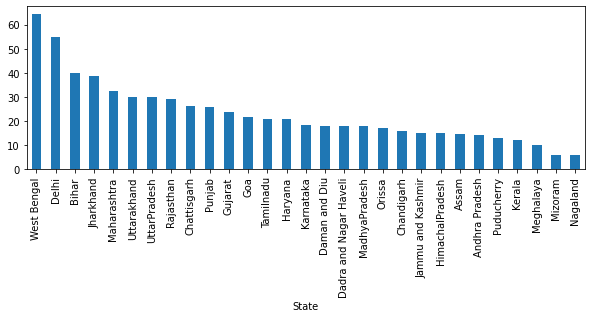

The 5 most polluted states with NO2 are West Bengal Delhi Bihar Jharkhand Maharashtra
The 5 least polluted states with NO2 are Puducherry Kerala Meghalaya Mizoram Nagaland


Average PM10 per state


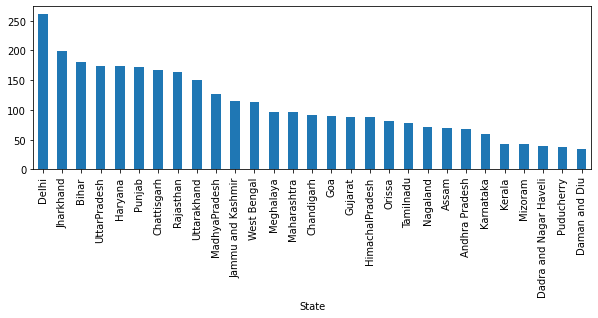

The 5 most polluted states with PM10 are Delhi Jharkhand Bihar UttarPradesh Haryana
The 5 least polluted states with PM10 are Kerala Mizoram Dadra and Nagar Haveli Puducherry Daman and Diu


Average SO2 per state


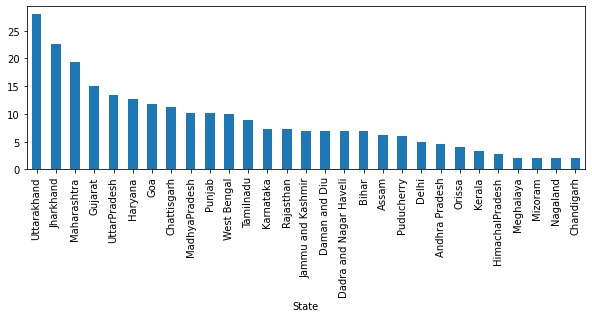

The 5 most polluted states with SO2 are Uttarakhand Jharkhand Maharashtra Gujarat UttarPradesh
The 5 least polluted states with SO2 are HimachalPradesh Meghalaya Mizoram Nagaland Chandigarh




In [19]:
# plotting mean values per state for each pollutant
for variable in df_state.columns:
    print('Average',variable,'per state')
    df_state[variable].sort_values(ascending=False).plot.bar(figsize=(10,3))
    plt.show()
    print('The 5 most polluted states with', variable,'are',*df_state[variable].sort_values(ascending=False).index[:5].tolist())
    print('The 5 least polluted states with', variable,'are',*df_state[variable].sort_values(ascending=False).index[-5:].tolist())
    print('\n')

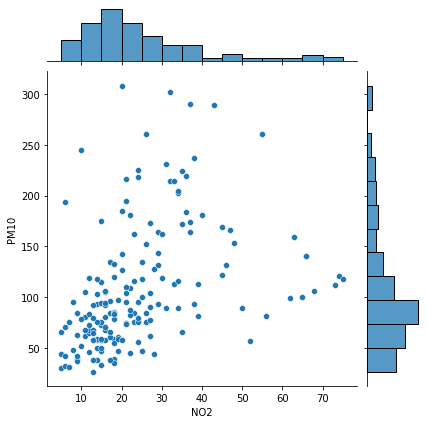

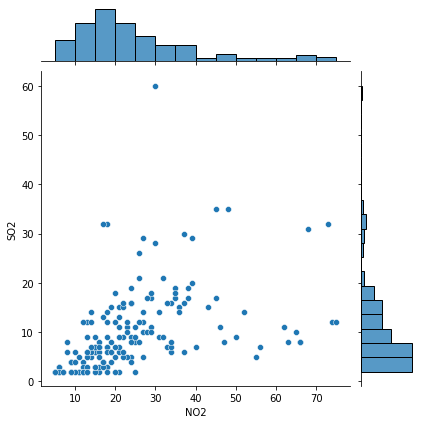

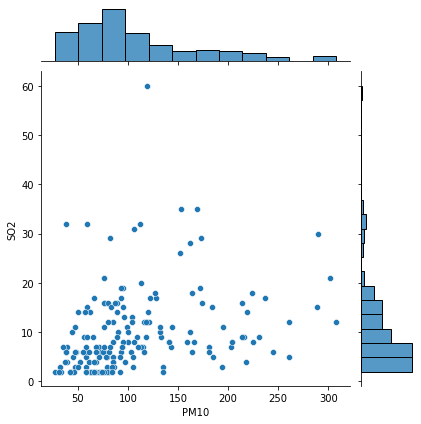

In [20]:
# plotting scatterplots with pairs of numerical variables
# for cities
sns.jointplot(data=df, x='NO2', y='PM10')
sns.jointplot(data=df, x='NO2', y='SO2')
sns.jointplot(data=df, x='PM10', y='SO2')

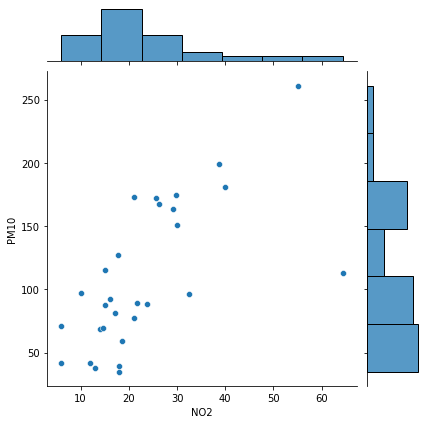

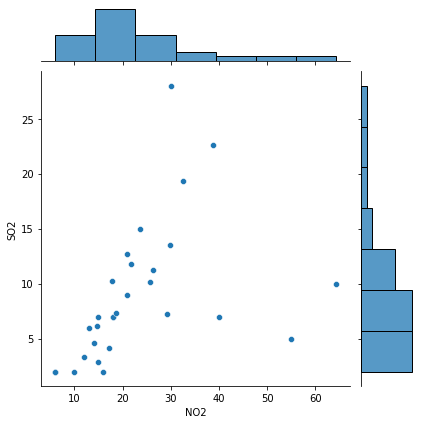

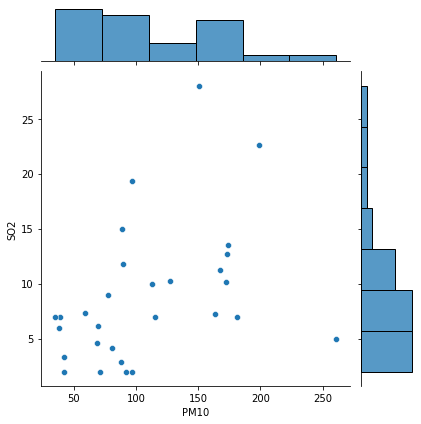

In [21]:
# plotting scatterplots with pairs of numerical variables
# for states
sns.jointplot(data=df_state, x='NO2', y='PM10')
sns.jointplot(data=df_state, x='NO2', y='SO2')
sns.jointplot(data=df_state, x='PM10', y='SO2')

<h2>2. Feature Engineering</h2>

In [22]:
# scaling
# creating scaler
scaler = MinMaxScaler()
#  fittinh  the scaler
scaler.fit(df[num_vars]) 
# transforming the data set
df[num_vars] = pd.DataFrame(scaler.transform(df[num_vars]),columns=num_vars)
# saving the scaler
joblib.dump(scaler, 'minmax_scaler.joblib')

['minmax_scaler.joblib']

Assumption: data missing at random

In [23]:
# missing values imputation
# using Multivariate Imputation by Chained Equation (MICE)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10,
                       verbose=2, imputation_order='roman',random_state=0)
df[num_vars]=imp.fit_transform(df[num_vars])

[IterativeImputer] Completing matrix with shape (181, 3)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.01
[IterativeImputer] Change: 0.16770635959225053, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.01
[IterativeImputer] Change: 0.04160599555023606, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.02
[IterativeImputer] Change: 0.005767850049215484, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.02
[IterativeImputer] Change: 0.0007995941212202984, scaled tolerance: 0.001 
[IterativeImputer] Early stopping criterion reached.


In [24]:
# making a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

# determining percentage of missing values (expressed as decimals)
# and displaying the result ordered by percent of missin data

df[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

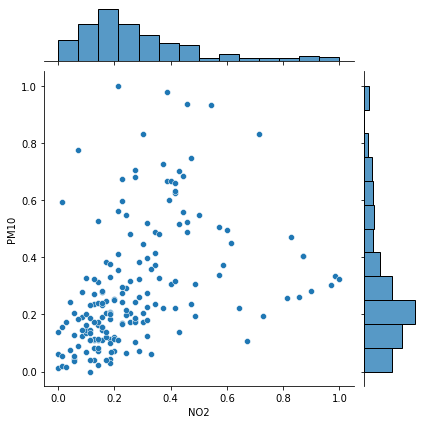

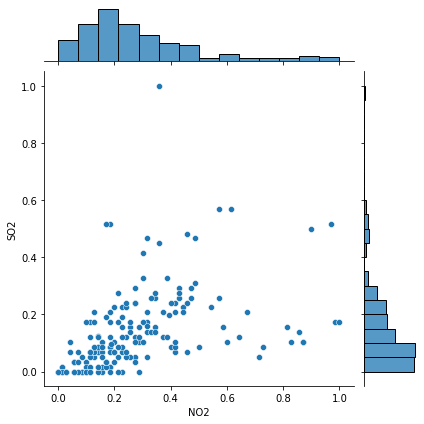

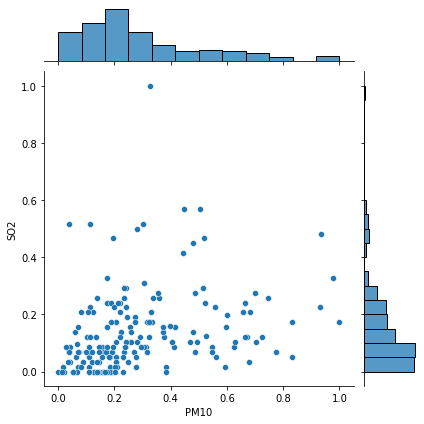

In [25]:
# plotting scatterplots with pairs of numerical variables
# for cities again after missing values imputation
sns.jointplot(data=df, x='NO2', y='PM10')
sns.jointplot(data=df, x='NO2', y='SO2')
sns.jointplot(data=df, x='PM10', y='SO2')

<h2>3. Feature Sselection</h2>

Selected features

In [26]:
num_vars

['NO2', 'PM10', 'SO2']

In [27]:
# defining X
X = df[num_vars].values

<h2>4. Clustering</h2>

<h3>Agglomerative clustering, 2 clusters</h3>

In [28]:
# defining a model
model = AgglomerativeClustering(n_clusters=2)
# fitting the model and predict clusters
y_ac = model.fit_predict(X)
# retrieving unique clusters
clusters = np.unique(y_ac)
clusters

array([0, 1])

Text(0.5, 0, 'SO2')

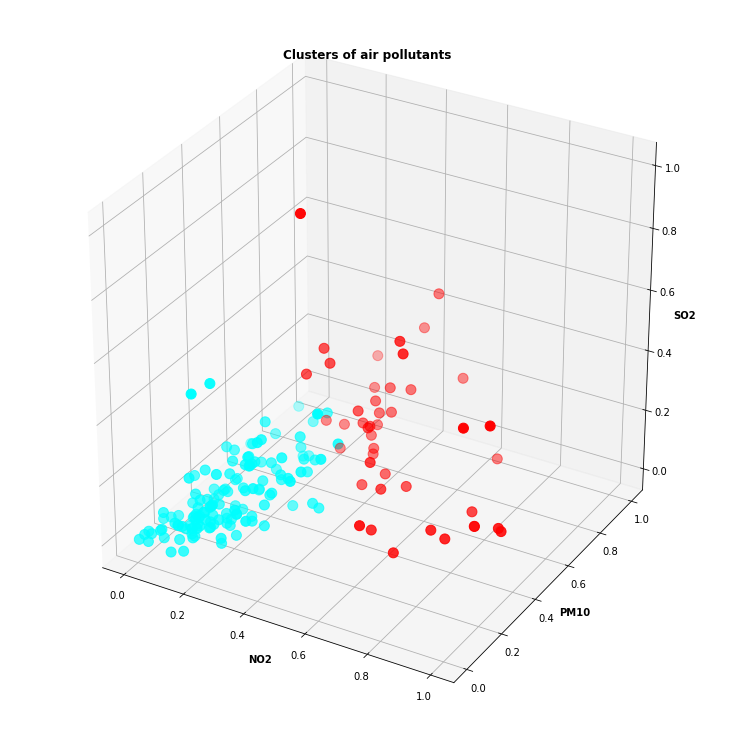

In [29]:
# plotting the clusters
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(X[y_ac==0,0], X[y_ac==0,1], X[y_ac==0,2], c='red', s=100, label='Cluster 1')
ax.scatter(X[y_ac==1,0], X[y_ac==1,1], X[y_ac==1,2], c='cyan', s=100, label='Cluster 2')
    
# defining title and labels and showing the plot
plt.title('Clusters of air pollutants', fontweight='bold')
ax.set_xlabel('NO2', fontweight='bold')
ax.set_ylabel('PM10', fontweight='bold')
ax.set_zlabel('SO2', fontweight='bold')

<h3>Agglomerative clustering, 3 clusters</h3>

In [30]:
# defining a model
model = AgglomerativeClustering(n_clusters=3)
# fitting the model and predict clusters
y_ac = model.fit_predict(X)
# retrieving unique clusters
clusters = np.unique(y_ac)
clusters

array([0, 1, 2])

Text(0.5, 0, 'SO2')

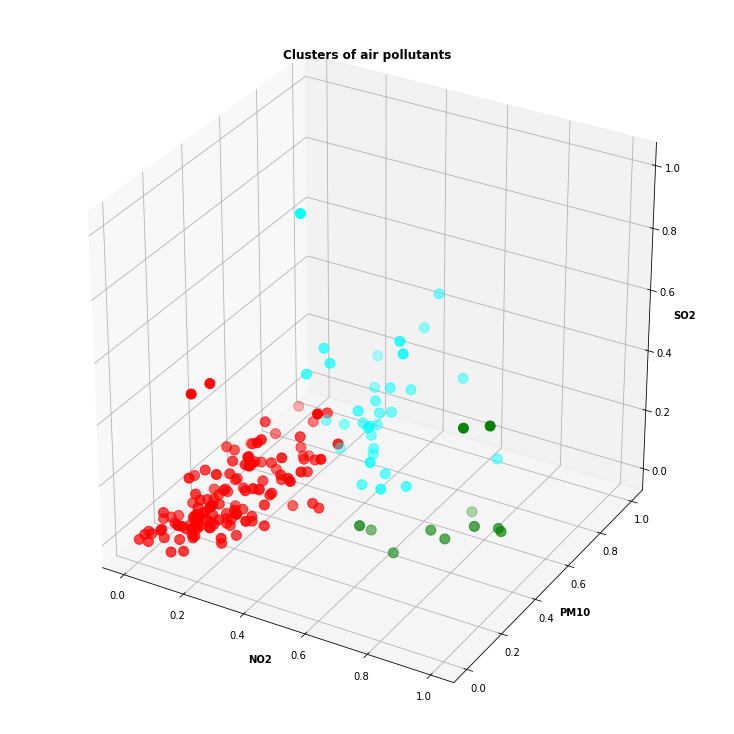

In [31]:
# plotting the clusters
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(X[y_ac==0,0], X[y_ac==0,1], X[y_ac==0,2], c='red', s=100, label='Cluster 1')
ax.scatter(X[y_ac==1,0], X[y_ac==1,1], X[y_ac==1,2], c='cyan', s=100, label='Cluster 2')
ax.scatter(X[y_ac==2,0], X[y_ac==2,1], X[y_ac==2,2], c='green', s=100, label='Cluster 3')
    
# defining title and labels and showing the plot
plt.title('Clusters of air pollutants', fontweight='bold')
ax.set_xlabel('NO2', fontweight='bold')
ax.set_ylabel('PM10', fontweight='bold')
ax.set_zlabel('SO2', fontweight='bold')

<h3>Agglomerative clustering, 4 clusters</h3>

In [32]:
# defining a model
model = AgglomerativeClustering(n_clusters=4)
# fitting the model and predict clusters
y_ac = model.fit_predict(X)
# retrieving unique clusters
clusters = np.unique(y_ac)
clusters

array([0, 1, 2, 3])

Text(0.5, 0, 'SO2')

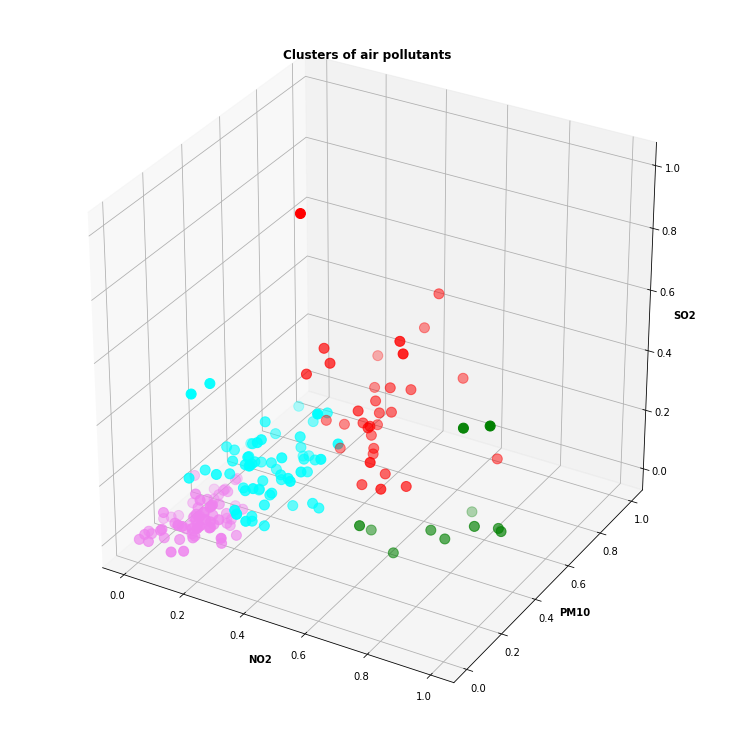

In [33]:
# plotting the clusters
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(X[y_ac==0,0], X[y_ac==0,1], X[y_ac==0,2], c='red', s=100, label='Cluster 1')
ax.scatter(X[y_ac==1,0], X[y_ac==1,1], X[y_ac==1,2], c='cyan', s=100, label='Cluster 2')
ax.scatter(X[y_ac==2,0], X[y_ac==2,1], X[y_ac==2,2], c='green', s=100, label='Cluster 3')
ax.scatter(X[y_ac==3,0], X[y_ac==3,1], X[y_ac==3,2], c='violet', s=100, label='Cluster 4')

# defining title and labels and showing the plot
plt.title('Clusters of air pollutants', fontweight='bold')
ax.set_xlabel('NO2', fontweight='bold')
ax.set_ylabel('PM10', fontweight='bold')
ax.set_zlabel('SO2', fontweight='bold')

<h3>Agglomerative clustering, 5 clusters</h3>

In [34]:
# defining a model
model = AgglomerativeClustering(n_clusters=5)
# fitting the model and predict clusters
y_ac = model.fit_predict(X)
# retrieving unique clusters
clusters = np.unique(y_ac)
clusters

array([0, 1, 2, 3, 4])

Text(0.5, 0, 'SO2')

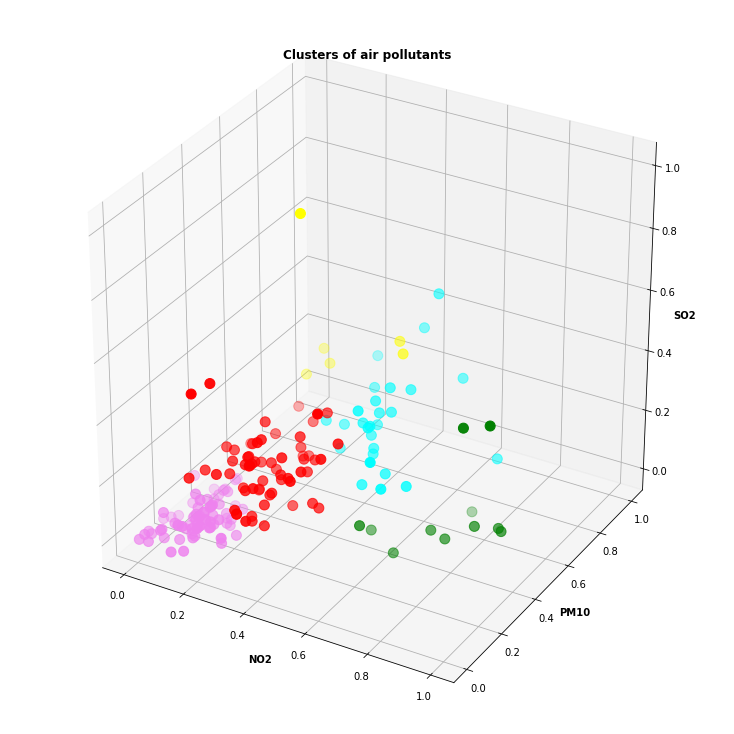

In [35]:
# plotting the clusters
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(X[y_ac==0,0], X[y_ac==0,1], X[y_ac==0,2], c='red', s=100, label='Cluster 1')
ax.scatter(X[y_ac==1,0], X[y_ac==1,1], X[y_ac==1,2], c='cyan', s=100, label='Cluster 2')
ax.scatter(X[y_ac==2,0], X[y_ac==2,1], X[y_ac==2,2], c='green', s=100, label='Cluster 3')
ax.scatter(X[y_ac==3,0], X[y_ac==3,1], X[y_ac==3,2], c='violet', s=100, label='Cluster 4')
ax.scatter(X[y_ac==4,0], X[y_ac==4,1], X[y_ac==4,2], c='yellow', s=100, label='Cluster 5')

# defining title and labels and showing the plot
plt.title('Clusters of air pollutants', fontweight='bold')
ax.set_xlabel('NO2', fontweight='bold')
ax.set_ylabel('PM10', fontweight='bold')
ax.set_zlabel('SO2', fontweight='bold')

<h3>DBSCAN (Density-Based Spatial Clustering of Applications with Noise), 4 clusters</h3>

In [36]:
# selecting epsilon
for eps in np.arange(0.01, 0.51, 0.02):
    # defining a model
    model = DBSCAN(eps)
    # fitting the model and predicting clusters
    y_dbscan = model.fit_predict(X)
    # retrieving unique clusters
    clusters = np.unique(y_dbscan)
    print(f"epsilon: {eps}, clusters{clusters}")

epsilon: 0.01, clusters[-1]
epsilon: 0.03, clusters[-1  0  1]
epsilon: 0.049999999999999996, clusters[-1  0  1]
epsilon: 0.06999999999999999, clusters[-1  0  1]
epsilon: 0.08999999999999998, clusters[-1  0  1]
epsilon: 0.10999999999999997, clusters[-1  0  1]
epsilon: 0.12999999999999998, clusters[-1  0]
epsilon: 0.15, clusters[-1  0]
epsilon: 0.16999999999999998, clusters[-1  0  1]
epsilon: 0.18999999999999997, clusters[-1  0  1]
epsilon: 0.20999999999999996, clusters[-1  0]
epsilon: 0.22999999999999998, clusters[-1  0]
epsilon: 0.24999999999999997, clusters[-1  0]
epsilon: 0.26999999999999996, clusters[-1  0]
epsilon: 0.29, clusters[-1  0]
epsilon: 0.30999999999999994, clusters[-1  0]
epsilon: 0.32999999999999996, clusters[-1  0]
epsilon: 0.35, clusters[-1  0]
epsilon: 0.36999999999999994, clusters[-1  0]
epsilon: 0.38999999999999996, clusters[-1  0]
epsilon: 0.4099999999999999, clusters[-1  0]
epsilon: 0.42999999999999994, clusters[-1  0]
epsilon: 0.44999999999999996, clusters[-1  0]

In [37]:
# defining a model
eps=0.18
model = DBSCAN(eps)
# fitting the model and predicting clusters
y_dbscan = model.fit_predict(X)
# retrieving unique clusters
clusters = np.unique(y_dbscan)
print(f"epsilon: {eps}, clusters{clusters}")

epsilon: 0.18, clusters[-1  0  1]


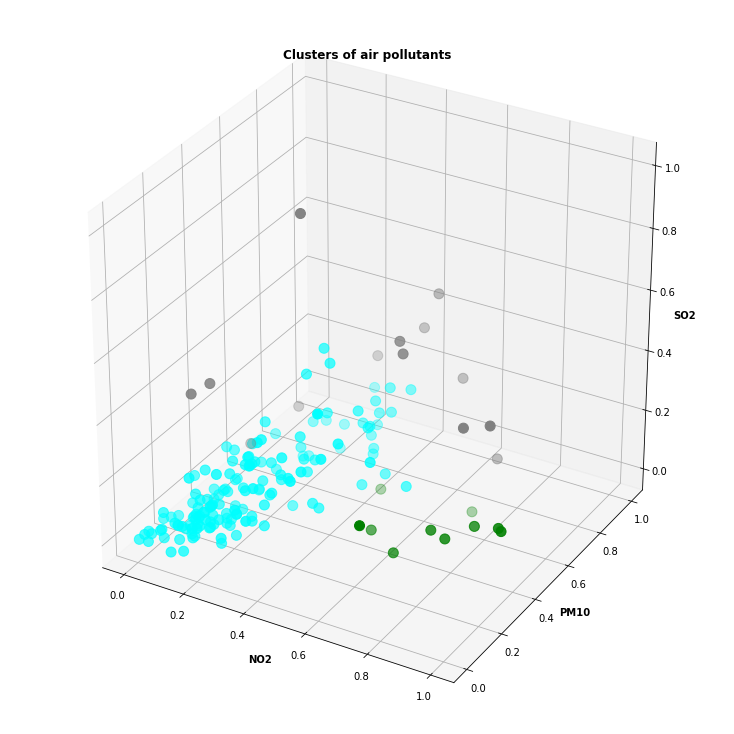

In [38]:
# plotting the clusters
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(X[y_dbscan==-1,0], X[y_dbscan==-1,1], X[y_dbscan==-1,2],
           c='grey', s=100, label='Outliers')
ax.scatter(X[y_dbscan==0,0], X[y_dbscan==0,1], X[y_dbscan==0,2],
           c='cyan', s=100, label='Cluster 1')
ax.scatter(X[y_dbscan==1,0], X[y_dbscan==1,1], X[y_dbscan==1,2],
           c='green', s=100, label='Cluster 2')
    
# defining title and labels and showing the plot
plt.title('Clusters of air pollutants', fontweight='bold')
ax.set_xlabel('NO2', fontweight='bold')
ax.set_ylabel('PM10', fontweight='bold')
ax.set_zlabel('SO2', fontweight='bold')

plt.show()

Agglomerative clustering with 3 clusters shows separation that makes sense for me. Let's see it again.

In [39]:
# defining a model
model = AgglomerativeClustering(n_clusters=3)
# fitting the model and predict clusters
y_ac = model.fit_predict(X)
# retrieving unique clusters
clusters = np.unique(y_ac)
clusters

array([0, 1, 2])

In [40]:
# inverse transformation
X = scaler.inverse_transform(X)

Text(0.5, 0, 'SO2')

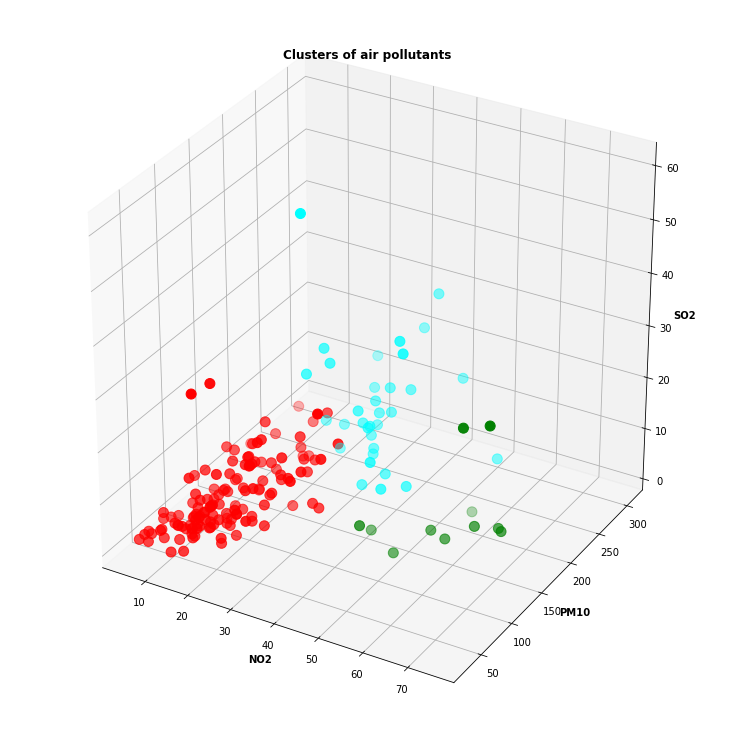

In [41]:
# plotting the clusters
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

ax.scatter(X[y_ac==0,0], X[y_ac==0,1], X[y_ac==0,2],
           c='red', s=100, label='Cluster 1')
ax.scatter(X[y_ac==1,0], X[y_ac==1,1], X[y_ac==1,2],
           c='cyan', s=100, label='Cluster 2')
ax.scatter(X[y_ac==2,0], X[y_ac==2,1], X[y_ac==2,2],
           c='green', s=100, label='Cluster 3')
    
# defining title and labels and showing the plot
plt.title('Clusters of air pollutants', fontweight='bold')
ax.set_xlabel('NO2', fontweight='bold')
ax.set_ylabel('PM10', fontweight='bold')
ax.set_zlabel('SO2', fontweight='bold')

In [42]:
# composing the dataframe with original pollutant intencities
# and clusters
df[num_vars] = X
y_ac += 1
df['Cluster'] = y_ac
df.head()

,City,State,NO2,PM10,SO2,Cluster
0,Chitoor,Andhra Pradesh,9.0,39.0,4.0,1
1,Guntur,Andhra Pradesh,11.0,81.0,2.0,1
2,Hydrabad,Andhra Pradesh,24.0,79.0,5.0,1
3,Kothagudem,Andhra Pradesh,11.0,62.0,2.0,1
4,Kurnool,Andhra Pradesh,9.0,85.0,4.0,1


In [43]:
# writing result to csv
df.to_csv('pollution_india_2010_result.csv')

<h2>5. Discussion</h2>

Agglomerative clustering with 3 clusters shows separation that makes sense for me. Red cluster 1 comprises the least polluted areas by all means. Light blue cluster 2 comprises the most polluted areas. Green cluster 3 low in 'SO2' and high with 'NO2' and 'PM10'.